In [1]:
%%capture
pip install transformers

In [2]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

# BERT MLM

In [3]:
bert = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer  = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
data = []
for _ in range(10):
    input_ids = torch.randint(0, len(tokenizer), (16, 256))
    data.append(input_ids)


In [5]:
bert.cuda();

In [6]:
import time

In [7]:
optimizer = torch.optim.AdamW(bert.parameters(), lr=1e-3)

start = time.time()

for input_ids in data:
    out = bert(input_ids=input_ids.cuda(), labels=input_ids.cuda())
    out.loss.backward()
    optimizer.step()
end = time.time()
print((end-start) / 10.0)

0.9141509056091308


In [8]:
print("Time for 1M steps (in days):", int(1e6 * (end-start) / 10 / 3600 / 24))

Time for 1M steps (in days): 10


# Gradient accumulation

In [9]:
def f(x):
    return (0.5 * x**2).sum()

Here we have:
\begin{equation}
\dfrac{\partial}{\partial x_i} f(x) = x_i.
\end{equation}

In [10]:
x = torch.arange(10, dtype=float, requires_grad=True)
x

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64,
       requires_grad=True)

In [11]:
x = torch.arange(10, dtype=float, requires_grad=True)

loss = f(x)
loss.backward()
print("Gradient of x:", x.grad)

Gradient of x: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64)


In [12]:
x = torch.arange(10, dtype=float, requires_grad=True)
print("Initial gradient:", x.grad)
for i in range(2):
    loss = f(x)
    loss.backward()
    input("Continue")
    print(f"Gradient of x at step {i}:", x.grad)

Initial gradient: None
Continue
Gradient of x at step 0: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64)
Continue
Gradient of x at step 1: tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.], dtype=torch.float64)


A gradient accumulation is readily performed like:

In [13]:
bert = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer  = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
data = []
batch_size = 2
for _ in range(10):
    input_ids = torch.randint(0, len(tokenizer), (batch_size, 8))
    data.append(input_ids)

In [15]:
bert.cuda();

In [16]:
optimizer = torch.optim.AdamW(bert.parameters(), lr=1e-3)


iteration_steps = 0
optimization_steps = 0
gradient_accumulation = 2

for input_ids in data:
    out = bert(input_ids=input_ids.cuda(), labels=input_ids.cuda())
    loss = out.loss

    loss = loss / gradient_accumulation # To average the gradient, otherwise it performs summazation.
    loss.backward()

    iteration_steps += 1

    if (iteration_steps % gradient_accumulation) == 0:
        optimizer.step()
        optimizer.zero_grad()
        optimization_steps += 1

print("Total number of data iterations:", iteration_steps)
print("Total number of opimization steps:", optimization_steps)

Total number of data iterations: 10
Total number of opimization steps: 5


# BART memory requirements

Make sure to free the cuda memory before running this (you can relaunch the notebook for instance).

In [1]:
from transformers import AutoModelForSeq2SeqLM

In [2]:
bart = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large")


config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [3]:
bart = bart.cuda();

In [4]:
!nvidia-smi

Wed Nov 22 10:31:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |   1663MiB / 15360MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Attention quadratic
relaunch the notebook as well

In [6]:
from transformers import BertConfig, BertForMaskedLM
import torch

In [2]:
bert_config = BertConfig(**{
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,

  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 246 * 3,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 4096,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": False,
  "vocab_size": 30522
})

In [9]:
bert = BertForMaskedLM(bert_config)

In [7]:
data = []
for L in [256, 512, 1024, 2048, 4096]:
    input_ids = torch.randint(0, 30522, (1, L))
    data.append(input_ids)

In [10]:
bert.cuda();

In [11]:
import matplotlib.pyplot as plt

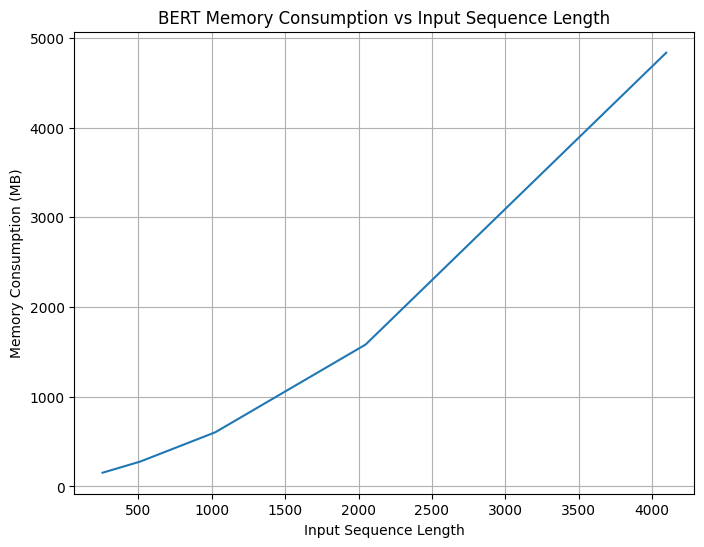

In [12]:
memory_cost = []
for input_ids in data:
    out = bert(input_ids=input_ids.cuda(), labels=input_ids.cuda())
    memory_cost.append(torch.cuda.memory_allocated(0) // 2**20)
plt.figure(figsize=(8, 6))
plt.plot([256, 512, 1024, 2048, 4096], memory_cost, linestyle='-')

# Adding labels and title
plt.xlabel('Input Sequence Length')
plt.ylabel('Memory Consumption (MB)')
plt.title('BERT Memory Consumption vs Input Sequence Length')

# Adding grid for better readability
plt.grid(True)
plt.show()

In [14]:
%%capture
pip install evaluate;

In [15]:
import nltk
import matplotlib.pyplot as plt
import evaluate


In [16]:
bleu = evaluate.load("bleu")

In [17]:
def compute_bleu(reference, candidate):
    # Tokenize the reference and candidate texts

    # Calculate BLEU score
    bleu_score = bleu.compute(references=[[reference]], predictions=[candidate])

    return bleu_score["bleu"]


In [18]:

# Example usage:
reference_text = "The quick brown fox jumps over the lazy dog."
candidate_text = "The fast brown fox jumps over the sleeping dog."
bleu_score = compute_bleu(reference_text, candidate_text)
print(f"BLEU Score: {bleu_score}")

BLEU Score: 0.4671379777282001
